In [2]:
# ms-python.python added
from sklearn.mixture import GaussianMixture
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import os
try:
    os.chdir(os.path.join(os.getcwd(), 'notebooks/report'))
    print(os.getcwd())
except:
    pass

In [3]:
get_ipython().run_line_magic('matplotlib', 'inline')
sns.set()

In [4]:
cd /mnt/sda/otani/Experiments/moment_retrieval/

/mnt/sda/otani/Experiments/moment_retrieval


# Query-aware temporal candidate generation

Input: description

Output: \mu and \sigma of starting point and duration

In [5]:
import torch
from torch import nn
from torch.distributions import MultivariateNormal, Independent
from torchvision.ops import roi_align

class QueryEmbedNet(nn.Module):
    def __init__(self, n_vocab, latent_size=100):
        super(QueryEmbedNet, self).__init__()
        
        self.emb = nn.Embedding(n_vocab+1, embedding_dim=100, padding_idx=n_vocab)
        self.lstm = nn.LSTM(100, latent_size)
        
    def forward(self, x):
        embeddings = self.emb(x)
        _, (h_n, _) = self.lstm(embeddings)
        return embeddings, h_n.squeeze()
        

class BoundaryDist(nn.Module):
    def __init__(self, latent_size=100):
        super(BoundaryDist, self).__init__()
        self.scale_l = nn.Linear(latent_size, 2)
        self.cov_l = nn.Linear(latent_size, 1)
        self.loc_l = nn.Linear(latent_size, 2)
        
    def forward(self, x):
        scale = torch.sigmoid(self.scale_l(x))
        cov = torch.tanh(self.cov_l(x))
        
        scale = torch.diag_embed(scale)
        scale[:,1,0] = torch.flatten(cov)
        
        loc = torch.sigmoid(self.loc_l(x))
        
        dist = MultivariateNormal(loc, scale_tril=scale)
        return dist
    
# class VideoNet(nn.Module):
#     def __init__(self, in_size, latent_size=512):
#         super(VideoNet, self).__init__()
# #         self.fc0 = nn.Linear(in_size,latent_size)
#         self.fc1 = nn.Linear(in_size, latent_size)
        
#     def forward(self, x, boxes):
#         """
#         ~~x: video B x C x 1 x T~~
#         x: video B x T x C
#         boxes: list of box. Each item of the list is 
#                 Tensor(n, 4). (x1, y1, x2, y2)
#         """
#         B, T, _ = x.shape
# #         h = torch.relu(self.fc0(x))
#         h = x
#         h = h.transpose(1,2).view(B, -1, 1, T)
#         h = roi_align(h, boxes, [1,1]).squeeze()
#         h = torch.relu(self.fc1(h))
#         return h

class VideoNet(nn.Module):
    def __init__(self, in_size, latent_size=512):
        super(VideoNet, self).__init__()
#         self.fc0 = nn.Linear(in_size,latent_size)
        self.fc1 = nn.Linear(in_size, latent_size)
        
    def forward(self, X, boxes):
        """
        ~~x: video B x C x 1 x T~~
        x: List of video features. Each item is Tensor(t, c)
        boxes: List of box. Each item of the list is 
                Tensor(n, 4). (x1, y1, x2, y2)
        """
        Y = []
        for x, b in zip(X, boxes):
            x = x.transpose(1,0)
            x = x[None,:,None,:]
            y = roi_align(x, [b], [1,1])
            y = y.squeeze()
            y = torch.relu(self.fc1(y))
            Y.append(y)
        return Y
    
class RelevanceNet(nn.Module):
    def __init__(self, latent_size=512):
        super(RelevanceNet, self).__init__()
        self.lstm0 = nn.LSTM(100, latent_size)
        self.lstm1 = nn.LSTM(latent_size*2, latent_size)
        self.fc0 = nn.Linear(latent_size, latent_size//2)
        self.fc1 = nn.Linear(latent_size//2, 1)
    
    def forward(self, X, embeddings):
        """
        X: list of clip features.
        """
        h0, (_, _) = self.lstm0(embeddings)
        S = []
        for i, x in enumerate(X):
            x, y = torch.broadcast_tensors(x[None,:,:], h0[:,i,:][:,None,:])
            xy = torch.cat([x, y], dim=-1)
            output, (h, _) = self.lstm1(xy)
            h = torch.squeeze(h)
        
            h = torch.relu(self.fc0(h))
            s = torch.sigmoid(self.fc1(h))
            S.append(s)
        return S
        

# DataLoader

- word indices
- normalized starting point
- normalized duration

In [6]:
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_punctuation, stem_text, strip_multiple_whitespaces
from torch.utils.data import Dataset
# from chainer.dataset import DatasetMixin
from torch.nn.utils.rnn import pad_sequence
import os
import h5py

def load_dataset_file(df_file):
    df = pd.read_csv(df_file)
    indices = np.where(df['end (sec)'] - df['start (sec)'] < 0)
    df = df.drop(index=indices[0])
    df['start (norm)'] = df['start (sec)']/df['length']
    df['end (norm)'] = df['end (sec)']/df['length']
    df['moment duration (norm)'] = df['end (norm)'] - df['start (norm)']
    return df

def preprocess_desc(desc):
    CUSTOM_FILTERS = [lambda x: x.lower(), strip_punctuation, strip_multiple_whitespaces, stem_text]
    desc = [preprocess_string(s, CUSTOM_FILTERS) for s in desc]
    return desc

def save_dict(df_file, out_file):
    df = load_dataset_file(df_file)
    desc = preprocess_desc(df['description'])
    dictionary = Dictionary(desc)
    dictionary.compactify()
    dictionary.save_as_text(out_file)

class CharadeData(Dataset):
    
    def __init__(self, split, dictionary_file, san_check=False):
        # load dictionary
#         self.vfeat_hf = h5py.File(f"data/processed/{split}_vfeat.h5", "r")
        self.vfeat_hf = h5py.File(f"data/processed/slowfast/{split}.h5", "r")
        self.dictionary = Dictionary.load_from_text(dictionary_file)
        
        df = load_dataset_file(f"data/processed/{split}.csv")
        
        if san_check:
            df = df[:500]
        
        # preprocessing
        self.video = df['id'].values
        self.desc = preprocess_desc(df['description'])
        self.start = df['start (norm)'].values
        self.duration = df['moment duration (norm)'].values
        self.n_vocab = len(self.dictionary)
        self.unknown_word_index = self.n_vocab
    
    def __del__(self):
        self.vfeat_hf.close()
    
    
    def __len__(self):
        return len(self.desc)
        
    def load_vfeat(self, i):
        video = self.video[i]
        v_feat = self.vfeat_hf[video][:]
        return v_feat.astype('f')
    
    def __getitem__(self, i):
        desc = self.desc[i]
        desc_i = self.dictionary.doc2idx(desc, unknown_word_index=self.unknown_word_index)
        v_feat = self.load_vfeat(i)
        n = len(v_feat)
        strt = self.start[i]
        dur = self.duration[i]
        n = len(v_feat)
        return desc_i, v_feat, (strt, dur, n)
    
def proc_batch(batch, pad_val=389):
    desc = pad_sequence([torch.tensor(b[0]) for b in batch],
                       padding_value=pad_val)
    v_feat = [torch.tensor(b[1]) for b in batch]
#     v_feat = pad_sequence([torch.tensor(b[1]) for b in batch])
#     v_feat = v_feat.transpose(0, 1)
    time = torch.tensor([b[-1] for b in batch])
    return desc, v_feat, time
# save_dict('data/processed/train.csv',
#               'data/processed/dictionary.txt')

# data_loader = DataLoader('data/processed/train.csv','data/processed/dictionary.txt')

# Utils

In [7]:
def iou(pred_s, pred_e, true_s, true_e):
    assert true_s < true_e, "true value invalid: (%.2f, %.2f)"%(true_s, true_e)
    if pred_s > pred_e:
        print("predicted value invalid: (%.2f, %.2f)"%(pred_s, pred_e))
        return 0

    union = min(pred_s, true_s), max(pred_e, true_e)
    intersection = max(pred_s, true_s), min(pred_e, true_e)

    if intersection[0] > intersection[1]:
        return 0

    iou_val = (intersection[1] - intersection[0]) / (union[1] - union[0])
    
    return iou_val

def convert_tbox(t_box, n, scores=None, device=None):
    """
    tbox: N x B x 2
    tbox (start, duration) -> (start, end)
    """
    N, B, _ = t_box.shape
    C = 4 if scores is None else 5
    out_box = torch.zeros((N, B, C)).to(device)
    
    st = torch.clamp(t_box[:,:,0], min=0, max=1.)
    dur = torch.clamp(t_box[:,:,1], min=0, max=1.)
    ed = torch.clamp(st + dur, max=1.)
    
    out_box[:,:,0] = st * n
    out_box[:,:,2] = ed * n
    out_box[:,:,3] = 1.
    
    if scores is not None:
        out_box[:,:,4] = scores
        
    out_box = [x[x[:, 0]!=x[:,2]] for x in torch.transpose(out_box, 0, 1)]
    return out_box

def get_label(proposals, target, thresh=0.7):
    """
    samples: list of temporal roi. N x 2 (start_time, end_time)
    time_stamp: B x 2 (start_time, duration)
    """
    iou_vals = []
    proposals = [p.detach().cpu() for p in proposals]
    target = target.detach().cpu()
    target[:, 1] = target.sum(axis=1)
    
    for i, item in enumerate(proposals):
        t_s, t_e = target[i]
        p_s = item[:, 0]
        p_e = item[:, 2]
        iou_val = [iou(s, e, t_s, t_e) for s, e in zip(p_s, p_e)]
        iou_vals+=iou_val
    iou_vals = np.asarray(iou_vals)
    labels = -np.ones(iou_vals.shape)
    labels[np.where(iou_vals>thresh)] = 1
    labels[np.where(iou_vals<.3)] = 0
    labels = torch.tensor(labels)
    return labels

def downsample(t_box, label):
    np_label = label.detach().to('cpu').numpy()
    indices = [len(t) for t in t_box]
    np_labels = np.split(np_label, np.cumsum(indices))
    
    out_t_box, out_label = [], []
    for t, l in zip(t_box, np_labels):
        n_positive_samples = (l==1).sum().item()
        n_negative_samples = (l==0).sum().item()
        sample_size = np.argmin([n_positive_samples, n_negative_samples, 30])
        
        if sample_size == 0:
            continue
        
        positive_samples = np.arange(len(l))[l==1]
        negative_samples = np.arange(len(l))[l==0]
        
        positive_samples = np.random.choice(positive_samples, sample_size)
        negative_samples = np.random.choice(negative_samples, sample_size)
        
        selected = np.hstack([positive_samples,
                             negative_samples])
        out_t_box.append(t[selected])
        out_label.append(l[selected])
    
    out_label = torch.tensor(np.hstack(out_label))
    return out_t_box, out_label

def non_maximum_suppression(bbox, thresh, score=None, limit=None):
    if len(bbox) == 0:
        return np.zeros((0,), dtype=np.int32)

    if score is not None:
        order = score.argsort()[::-1]
        bbox = bbox[order]

    bbox_area = bbox[:, 1] - bbox[:, 0]

    selec = np.zeros(bbox.shape[0], dtype=bool)
    
    for i, b in enumerate(bbox):
        if not bbox_area[i] > 0:
            continue
            
        if not selec.any():
            selec[i] = True
            continue
            
        st = np.maximum(b[0], bbox[selec, 0])
        ed = np.minimum(b[1], bbox[selec, 1])
        area = (ed - st) * (st < ed)
            
        iou = area / (bbox_area[i] + bbox_area[selec] - area)
        
        # when the temporal bbox highly overlap with any of selected bbox
        if (iou >= thresh).any(): 
            continue

        selec[i] = True
        if limit is not None and np.count_nonzero(selec) >= limit:
            break
    
    selec = np.where(selec)[0]
    if score is not None:
        selec = order[selec]
    return selec.astype(np.int32)

# Train proposal generator

In [8]:
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.optim as optim
from time import time

In [44]:
b_size = 200
epoch = 30
device_id = 0

use_cuda = torch.cuda.is_available()
device = torch.device(f"cuda:{device_id}" if use_cuda else "cpu")
# torch.cuda.set_device(device_id)

dict_file = 'data/processed/dictionary.txt'
dataset = CharadeData("train",
                  dict_file,
                 san_check=False)

n_train = int(len(dataset)*.8)
n_val = len(dataset) - n_train

train_data, val_data = random_split(dataset, (n_train,n_val))
train_iter = DataLoader(train_data, b_size, shuffle=True, collate_fn=proc_batch)
val_iter = DataLoader(val_data, b_size, shuffle=False, collate_fn=proc_batch)

query_net = QueryEmbedNet(dataset.n_vocab, latent_size=25)
boundary_dist = BoundaryDist(latent_size=25)

# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#     query_net = nn.DataParallel(query_net)
#     boundary_dist = nn.DataParallel(boundary_dist)

query_net.to(device)
boundary_dist.to(device)

query_net_opt = optim.Adam(query_net.parameters())
boundary_dist_opt = optim.Adam(boundary_dist.parameters())

for e in range(epoch):
    query_net.train()
    boundary_dist.train()
    for i, batch in enumerate(train_iter):
        start = time()
        desc, _, time_stamp = batch
        desc, time_stamp = desc.to(device), time_stamp.to(device)
        time_stamp, n = time_stamp[:, :2], time_stamp[:, -1]

        _, h = query_net(desc)
        d = boundary_dist(h)

        reconstruct = torch.mean(d.log_prob(time_stamp))
        loss = -reconstruct
        
        query_net_opt.zero_grad()
        boundary_dist_opt.zero_grad()
        loss.backward()
        query_net_opt.step()
        boundary_dist_opt.step()
        sec_iter = time() - start
        
        if (i % 10)==0:
            print(f"epoch:{e} iter: {i} loss: {loss.item():.3f} ({sec_iter:.2f} sec.)")
            
torch.save(query_net.state_dict(), "models/naive_vis_lng_prototype/query_net.pkl")
torch.save(boundary_dist.state_dict(), "models/naive_vis_lng_prototype/boundary_dist.pkl")

epoch:0 iter: 0 loss: 0.803 (0.00 sec.)
epoch:0 iter: 10 loss: 0.510 (0.00 sec.)
epoch:0 iter: 20 loss: 0.165 (0.00 sec.)
epoch:0 iter: 30 loss: -0.141 (0.00 sec.)
epoch:0 iter: 40 loss: -0.492 (0.01 sec.)
epoch:1 iter: 0 loss: -0.622 (0.01 sec.)
epoch:1 iter: 10 loss: -0.703 (0.00 sec.)
epoch:1 iter: 20 loss: -0.679 (0.01 sec.)
epoch:1 iter: 30 loss: -0.600 (0.01 sec.)
epoch:1 iter: 40 loss: -0.696 (0.01 sec.)
epoch:2 iter: 0 loss: -0.710 (0.01 sec.)
epoch:2 iter: 10 loss: -0.652 (0.01 sec.)
epoch:2 iter: 20 loss: -0.621 (0.00 sec.)
epoch:2 iter: 30 loss: -0.628 (0.00 sec.)
epoch:2 iter: 40 loss: -0.627 (0.00 sec.)
epoch:3 iter: 0 loss: -0.675 (0.00 sec.)
epoch:3 iter: 10 loss: -0.691 (0.00 sec.)
epoch:3 iter: 20 loss: -0.639 (0.00 sec.)
epoch:3 iter: 30 loss: -0.693 (0.00 sec.)
epoch:3 iter: 40 loss: -0.749 (0.00 sec.)
epoch:4 iter: 0 loss: -0.709 (0.00 sec.)
epoch:4 iter: 10 loss: -0.643 (0.00 sec.)
epoch:4 iter: 20 loss: -0.758 (0.00 sec.)
epoch:4 iter: 30 loss: -0.757 (0.00 sec.)


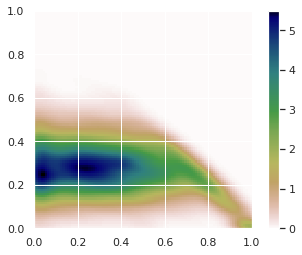

In [52]:
# sample temporal proposals from learned distributions

def sample_proposals(data, query_net, boundary_dist):
    b_size = 200
    device_id = 0
    use_cuda = torch.cuda.is_available()
    device = torch.device(f"cuda:{device_id}" if use_cuda else "cpu")

    data_loader = DataLoader(data, b_size, shuffle=False, collate_fn=proc_batch)

    res = []
    for batch in data_loader:
        desc, _, time_stamp = batch
        desc, time_stamp = desc.to(device), time_stamp.to(device)
        time_stamp, n = time_stamp[:, :2], time_stamp[:, -1]

        embs, h = query_net(desc)
        d = boundary_dist(h)

        sample = d.sample((5,)).view(-1, 2)
        sample = torch.squeeze(sample)

        sample = sample.to('cpu')
        res.append(sample.numpy())

    res = np.vstack(res)
    start = res[:, 0]
    duration = res[:, 1]

    start = np.clip(start, 0, 1)
    duration = np.min(np.vstack((duration, 1-start)), axis=0)
    return start, duration


query_net = QueryEmbedNet(dataset.n_vocab, latent_size=25)
boundary_dist = BoundaryDist(latent_size=25)

query_net.load_state_dict(torch.load("models/naive_vis_lng_prototype/query_net.pkl"))
boundary_dist.load_state_dict(torch.load("models/naive_vis_lng_prototype/boundary_dist.pkl"))

query_net.to(device)
boundary_dist.to(device)
query_net.eval()
boundary_dist.eval()

with torch.no_grad():
    start, duration = sample_proposals(val_data, query_net, boundary_dist)
    
kernel = gaussian_kde(np.vstack([start, duration]))
X, Y = np.mgrid[0:1:100j, 0:1:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)
plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[0, 1, 0, 1])
plt.colorbar()

In [58]:
# Eval proposal generator
dict_file = 'data/processed/dictionary.txt'
b_size = 200
device_id = 0
use_cuda = torch.cuda.is_available()
device = torch.device(f"cuda:{device_id}" if use_cuda else "cpu")

query_net = QueryEmbedNet(dataset.n_vocab, latent_size=25)
boundary_dist = BoundaryDist(latent_size=25)

query_net.load_state_dict(torch.load("models/naive_vis_lng_prototype/query_net.pkl"))
boundary_dist.load_state_dict(torch.load("models/naive_vis_lng_prototype/boundary_dist.pkl"))

query_net.to(device)
boundary_dist.to(device)

outputs = {
    'scores': [],
    'label': [],
    't_box': []
}

N = 200
data_loader = DataLoader(val_data, b_size, shuffle=False, collate_fn=proc_batch)
query_net.eval()
boundary_dist.eval()

with torch.no_grad():
    res = []
    for batch in data_loader:
        desc, _, time_stamp = batch
        desc, time_stamp = desc.to(device), time_stamp.to(device)
        time_stamp, n = time_stamp[:, :2], time_stamp[:, -1]
        
        embs, h = query_net(desc)
        d = boundary_dist(h)

        samples = d.sample((N,))
        t_scores = d.log_prob(samples)
        samples = convert_tbox(samples.detach(), n, t_scores, device)
        
        t_box = [t[:, :4] for t in samples]
        t_scores = [t[:, -1] for t in samples]

        time_stamp = time_stamp * n.view(-1, 1)

        label = get_label(t_box, time_stamp, .5)
        label = label.to(torch.float).to(device)

        outputs['scores'] += [s.cpu() for s in t_scores]
        outputs['label'] += torch.split(label.cpu().view(-1,), [len(x) for x in t_box])
        outputs['t_box'] += [x[:, [0, 2]].cpu() for x in t_box]

In [59]:
r_at_k = {
 1: [], 5: [], 10: []   
}

for i in range(len(test)):
    selected = non_maximum_suppression(outputs['t_box'][i].numpy(),
                                       0.5-0.05,
                                       outputs['scores'][i].numpy())

    for k in r_at_k.keys():
        r_at_k[k].append((outputs['label'][i].numpy()[selected][:k] > 0).any())

for k in r_at_k.keys():
    print(f"R@{k}:  {np.mean(r_at_k[k])}")

R@1:  0.242
R@5:  0.722
R@10:  0.912


# Train similarity estimator

In [9]:
b_size = 200
device_id = 0
iou_thresh = 0.7

use_cuda = torch.cuda.is_available()
device = torch.device(f"cuda:{device_id}" if use_cuda else "cpu")

dict_file = 'data/processed/dictionary.txt'
dataset = CharadeData("train",
                  dict_file,
                 san_check=False)

n_train = int(len(dataset)*.8)
n_val = len(dataset) - n_train

train_data, val_data = random_split(dataset, (n_train,n_val))
train_iter = DataLoader(train_data, b_size, shuffle=True, collate_fn=proc_batch)
val_iter = DataLoader(val_data, b_size, shuffle=False, collate_fn=proc_batch)

query_net = QueryEmbedNet(dataset.n_vocab, latent_size=25)
boundary_dist = BoundaryDist(latent_size=25)

query_net.load_state_dict(torch.load("models/naive_vis_lng_prototype/query_net.pkl"))
boundary_dist.load_state_dict(torch.load("models/naive_vis_lng_prototype/boundary_dist.pkl"))

video_net = VideoNet(2304, 512) # 4096 for charade feat, 2304 for slowfast feat
rel_net = RelevanceNet(512)

query_net.to(device)
boundary_dist.to(device)
video_net.to(device)
rel_net.to(device)

video_net_opt = optim.Adam(video_net.parameters(), lr=0.0001)
rel_net_opt = optim.Adam(rel_net.parameters(), lr=0.0001)
# query_net_opt = optim.Adam(query_net.parameters())
# boundary_dist_opt = optim.Adam(boundary_dist.parameters())

def init_params(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight)

video_net.apply(init_params)
rel_net.apply(init_params)

def forward(batch,
         query_net,
         boundary_dist,
        video_net,
        rel_net
        ):
    
        loss_fun = nn.MarginRankingLoss(.001)
        
        desc, v_feat, time_stamp = batch
        desc, time_stamp = desc.to(device), time_stamp.to(device)
        v_feat = [x.to(device) for x in v_feat]
        time_stamp, n = time_stamp[:, :2], time_stamp[:, -1]

        embs, h = query_net(desc)
        d = boundary_dist(h)

        t_box = d.sample((200,))
        t_box = convert_tbox(t_box, n, device=device)

        time_stamp = time_stamp * n.view(-1, 1)
        label = get_label(t_box, time_stamp, iou_thresh)
        
        t_box, label = downsample(t_box, label)

        label.to(device)
        
        v_h = video_net(v_feat, t_box)
        output = rel_net(v_h, embs.detach())
        output = torch.cat(output, dim=0)
        
        x1 = output[label==1]
        x2 = output[label==0]
        t = torch.ones_like(x1).to(device)

        loss = loss_fun(x1, x2, t)
        
        return loss
    

for e in range(10):
    query_net.eval()
    boundary_dist.eval()
    video_net.train()
    rel_net.train()
    
    for i, batch in enumerate(train_iter):
        start = time()
        loss = forward(batch,query_net,boundary_dist,video_net,rel_net)
        

        video_net_opt.zero_grad()
        rel_net_opt.zero_grad()
        loss.backward()
        video_net_opt.step()
        rel_net_opt.step()
        
        sec_iter = time() - start
        if (i%10)==0:
            print(f"epoch:{e} iter: {i} loss: {loss.item():.3f} ({sec_iter:.2f} sec.)")

    with torch.no_grad():
        query_net.eval()
        boundary_dist.eval()
        video_net.eval()
        rel_net.eval()
        loss_summary = []
        for batch in val_iter:
            loss = forward(batch,query_net,boundary_dist,video_net,rel_net)
            loss_summary.append(loss.item())
    print("validation: {:.3f}".format(sum(loss_summary) / len(loss_summary)))

epoch:0 iter: 0 loss: 0.001 (1.44 sec.)
epoch:0 iter: 10 loss: 0.001 (1.38 sec.)
epoch:0 iter: 20 loss: 0.001 (1.45 sec.)
epoch:0 iter: 30 loss: 0.002 (1.41 sec.)
epoch:0 iter: 40 loss: 0.001 (1.40 sec.)
validation: 0.001
epoch:1 iter: 0 loss: 0.001 (1.41 sec.)
epoch:1 iter: 10 loss: 0.001 (1.43 sec.)
epoch:1 iter: 20 loss: 0.001 (1.48 sec.)
epoch:1 iter: 30 loss: 0.001 (1.38 sec.)
epoch:1 iter: 40 loss: 0.002 (1.43 sec.)
validation: 0.001
epoch:2 iter: 0 loss: 0.002 (1.39 sec.)
epoch:2 iter: 10 loss: 0.001 (1.39 sec.)
epoch:2 iter: 20 loss: 0.001 (1.46 sec.)
epoch:2 iter: 30 loss: 0.001 (1.44 sec.)
epoch:2 iter: 40 loss: 0.001 (1.38 sec.)
validation: 0.001
epoch:3 iter: 0 loss: 0.001 (1.44 sec.)
epoch:3 iter: 10 loss: 0.001 (1.40 sec.)
epoch:3 iter: 20 loss: 0.001 (1.49 sec.)
epoch:3 iter: 30 loss: 0.001 (1.42 sec.)
epoch:3 iter: 40 loss: 0.001 (1.41 sec.)
validation: 0.001
epoch:4 iter: 0 loss: 0.002 (1.40 sec.)
epoch:4 iter: 10 loss: 0.001 (1.43 sec.)
epoch:4 iter: 20 loss: 0.001 (1

In [187]:
torch.save(video_net.state_dict(), "models/naive_vis_lng_prototype/video_net.pkl")
torch.save(rel_net_opt.state_dict(), "models/naive_vis_lng_prototype/rel_net_opt.pkl")

In [10]:
diff = []
for batch in train_iter:
    desc, v_feat, time_stamp = batch
    desc, time_stamp = desc.to(device), time_stamp.to(device)
    v_feat = [x.to(device) for x in v_feat]
    time_stamp, n = time_stamp[:, :2], time_stamp[:, -1]

    embs, h = query_net(desc)
    d = boundary_dist(h)

    t_box = d.sample((200,))
    t_box = convert_tbox(t_box, n, device=device)

    time_stamp = time_stamp * n.view(-1, 1)
    label = get_label(t_box, time_stamp, iou_thresh)

    t_box, label = downsample(t_box, label)
    label.to(device)

    v_h = video_net(v_feat, t_box)
    output = rel_net(v_h, embs.detach())
    output = torch.cat(output, dim=0)
    
    diff.append((output[label==1] - output[label==0]).detach().cpu().numpy().ravel())
    if len(diff) > 10:
        break

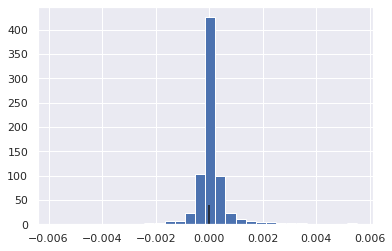

In [11]:
plt.hist(np.hstack(diff), bins=30)
plt.vlines(0, 0, 40)

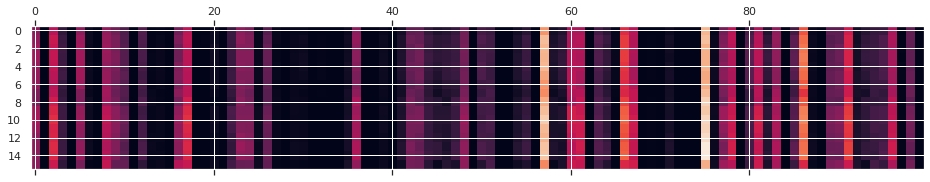

In [16]:
plt.matshow(v_feat[0].cpu().numpy()[:, :100])

# Evaluation

In [259]:
# Eval 
dict_file = 'data/processed/dictionary.txt'
b_size = 200
device_id = 0
use_cuda = torch.cuda.is_available()
device = torch.device(f"cuda:{device_id}" if use_cuda else "cpu")

query_net = QueryEmbedNet(dataset.n_vocab, latent_size=25)
boundary_dist = BoundaryDist(latent_size=25)
video_net = VideoNet(4096, 512)
rel_net = RelevanceNet(512)

query_net.load_state_dict(torch.load("models/naive_vis_lng_prototype/query_net.pkl"))
boundary_dist.load_state_dict(torch.load("models/naive_vis_lng_prototype/boundary_dist.pkl"))
video_net.load_state_dict(torch.load("models/naive_vis_lng_prototype/video_net.pkl"))
rel_net.load_state_dict(torch.load("models/naive_vis_lng_prototype/rel_net.pkl"))

query_net.to(device)
boundary_dist.to(device)
video_net.to(device)
rel_net.to(device)

outputs = {
    'proposal_scores': [],
    'matching_scores': [],
    'label': [],
    't_box': [],
    'timestamp': []
}

N = 200
data_loader = DataLoader(val_data, b_size, shuffle=False, collate_fn=proc_batch)
query_net.eval()
boundary_dist.eval()
video_net.eval()
rel_net.eval()

with torch.no_grad():
    res = []
    for i, batch in enumerate(data_loader):
        desc, v_feat, time_stamp = batch
        desc, time_stamp = desc.to(device), time_stamp.to(device)
        v_feat = [x.to(device) for x in v_feat]
        time_stamp, n = time_stamp[:, :2], time_stamp[:, -1]

        embs, h = query_net(desc)
        d = boundary_dist(h)

        t_box = d.sample((200,))
        t_scores = d.log_prob(t_box)
        t_box = convert_tbox(t_box, n, scores=t_scores, device=device)
        
        t_scores = [t[:, -1] for t in t_box]
        t_box = [t[:, :4] for t in t_box]
        
        time_stamp = time_stamp * n.view(-1, 1)
        label = get_label(t_box, time_stamp, 0.5)
        
        v_h = video_net(v_feat, t_box)
        output = rel_net(v_h, embs.detach())

        outputs['proposal_scores'] += [s.cpu().numpy().ravel() for s in t_scores]
        outputs['matching_scores'] += [o.cpu().numpy().ravel() for o in output]
        label = torch.split(label.cpu().view(-1,), [len(x) for x in t_box])
        outputs['label'] += [l.cpu().numpy().ravel() for l in label]
        outputs['t_box'] += [x[:, [0, 2]].cpu().numpy() for x in t_box]
        outputs['timestamp'].append(time_stamp.cpu().numpy())
        
        print(i)
            
outputs['timestamp'] = np.vstack(outputs['timestamp'])

0
1
2
3
4
5
6
7
8
9
10
11
12


In [260]:
r_at_k = {
 1: [], 5: [], 10: []   
}

for i in range(len(outputs['t_box'])):
    t_box = outputs['t_box'][i].copy()
    score = outputs['proposal_scores'][i] + outputs['matching_scores'][i]
    selected = non_maximum_suppression(t_box,
                                       0.5-0.05,
                                       score)
    res = outputs['label'][i][selected]
    
    for k in r_at_k.keys():
        r_at_k[k].append((res[:k] > 0).any())

for k in r_at_k.keys():
    print(f"R@{k}:  {np.mean(r_at_k[k])}")

R@1:  0.2623941958887545
R@5:  0.7779121322047562
R@10:  0.9383313180169287


In [261]:
r_at_k = {
 1: [], 5: [], 10: []   
}

for i in range(len(outputs['t_box'])):
    t_box = outputs['t_box'][i].copy()
    score = outputs['matching_scores'][i]
    selected = non_maximum_suppression(t_box,
                                       0.5-0.05,
                                       score)
    res = outputs['label'][i][selected]
    
    for k in r_at_k.keys():
        r_at_k[k].append((res[:k] > 0).any())

for k in r_at_k.keys():
    print(f"R@{k}:  {np.mean(r_at_k[k])}")

R@1:  0.09915356711003627
R@5:  0.5143087464731962
R@10:  0.8202337767029424


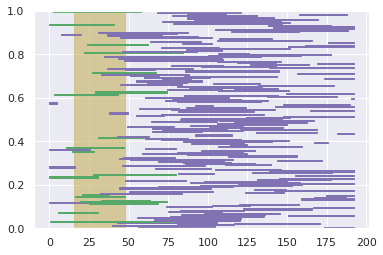

In [262]:
i = np.random.randint(len(outputs['label']))

gts = outputs['timestamp'][i]
samples = outputs['t_box'][i]
label = outputs['label'][i]
v_len = samples.max()
n_pred = len(samples)

plt.axvspan(gts[0], gts.sum(), color='y', alpha=.7)
for i, (s, e) in enumerate(samples):
    c = 'g' if label[i] else 'm'
    plt.axvspan(s, e, i*1/n_pred, (i+1)*1/n_pred, color=c)

In [32]:
test = CharadeData('test',
                  dict_file,
                  san_check=True)

outputs = {
    'scores': [],
    'label': [],
    't_box': []
}
N = 200
test_iter = DataLoader(test, b_size, shuffle=False, collate_fn=proc_batch)
query_net.eval()
boundary_dist.eval()

with torch.no_grad():
    res = []
    for batch in test_iter:
        desc, v_feat, time_stamp = batch
        desc, time_stamp = desc.to(device), time_stamp.to(device)
        time_stamp, n = time_stamp[:, :2], time_stamp[:, -1]
        
        embs, h = query_net(desc)
        d = boundary_dist(h)

        samples = d.sample((N,))
        t_scores = d.log_prob(samples)
        samples = convert_tbox(samples.detach(), n, t_scores, device)
        
        t_box = [t[:, :4] for t in samples]
        t_scores = [t[:, -1] for t in samples]
        indices = [len(x) for x in t_box]

        time_stamp = time_stamp * n.view(-1, 1)

        label = get_label(t_box, time_stamp, iou_thresh)
        label = label.to(torch.float).to(device)

#         v_h = video_net(v_feat.transpose(0,1), t_box)
#         v_h = torch.split(v_h, indices)
#         output = rel_net(v_h, embs.detach())
#         scores = torch.cat(output, dim=0)
#         scores = [s+o.view(-1,) for s,o in zip(t_scores, output)]
#         scores = torch.cat(t_scores, dim=0)
        
#         outputs['scores'] += torch.split(scores.cpu().view(-1,), [len(x) for x in t_box])
        outputs['scores'] += [s.cpu() for s in scores]
        outputs['label'] += torch.split(label.cpu().view(-1,), [len(x) for x in t_box])
        outputs['t_box'] += [x[:, [0, 2]].cpu() for x in t_box]

In [33]:
r_at_k = {
 1: [], 5: [], 10: []   
}

for i in range(len(test)):
    selected = non_maximum_suppression(outputs['t_box'][i].numpy(),
                                       0.5-0.05,
                                       outputs['scores'][i].numpy())

    for k in r_at_k.keys():
        r_at_k[k].append((outputs['label'][i].numpy()[selected][:k] > 0).any())

for k in r_at_k.keys():
    print(f"R@{k}:  {np.mean(r_at_k[k])}")

In [178]:
torch.save(query_net.state_dict(), "models/naive_vis_lng_prototype/query_net.pkl")
torch.save(boundary_dist.state_dict(), "models/naive_vis_lng_prototype/boundary_dist.pkl")
torch.save(video_net.state_dict(), "models/naive_vis_lng_prototype/video_net.pkl")
torch.save(rel_net.state_dict(), "models/naive_vis_lng_prototype/rel_net.pkl")

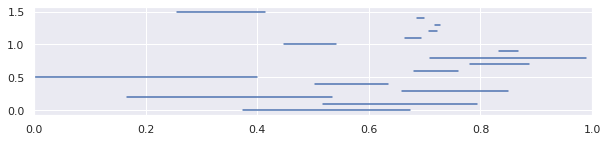

In [179]:
st = outputs['t_box'][-1][:,0].numpy()[selected]
ed = outputs['t_box'][-1][:,1].numpy()[selected]
i = 0
plt.figure(figsize=(10, 2))
for s, e in zip(st, ed):
    plt.axhline(i, s/120., e/120.)
    i+=0.1

In [180]:
outputs['label'][-1].numpy()[selected]

array([ 0.,  0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., -1.], dtype=float32)

In [141]:
# show example
i = np.random.randint(len(res))
true_s, true_d = res[i]['t']
true_e = true_s + true_d
plt.figure(figsize=(10, 2))
plt.axhline(0.1, true_s, true_s+true_d, color='g')
plt.xlim((0, 1))
plt.ylim((0, 1))

p_item = res[i]['y']
# p_item = p_item.reshape(-1, 2)
offset = 0.2
iou_val = []
lines = []
for pred_s, pred_d in p_item:
    pred_e = pred_s+pred_d
    line = plt.axhline(offset, pred_s, pred_e, color='b')
    offset += (0.8/len(p_item))
    iou_val.append(iou(pred_s, pred_e, true_s, true_e))
    lines.append(line)
print('max iou: %.1f' % max(iou_val))
if max(iou_val) > 0:
    lines[np.argmax(iou_val)].set_color('r')


ValueError: Range cannot be empty (low >= high) unless no samples are taken